In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re

In [2]:
GAMMAS = ['1.0','0.9','0.8','0.7','0.6','0.5','0.4','0.3','0.2','0.1']
INDEX_TIME_UNIT = 1000 # number of tweets
QUERY_TIME_UNIT = 1000 # number of tweets
SIMILARITY_THRE = 0.5
NUMBER_OF_RUNS = 3
OUTPUT_DIR = "./output_expm1/n28/"

def get_chance(gamma):
    if gamma == '1.0':
        return '100'
    elif gamma == '0.9':
        return '90'
    elif gamma == '0.8':
        return '80'
    elif gamma == '0.7':
        return '70'
    elif gamma == '0.6':
        return '60'
    elif gamma == '0.5':
        return '50'
    elif gamma == '0.4':
        return '40'
    elif gamma == '0.3':
        return '30'
    elif gamma == '0.2':
        return '20'
    elif gamma == '0.1':
        return '10'
    
def get_gamma_index(gamma):
    if gamma == '1.0':
        return 0
    elif gamma == '0.9':
        return 1
    elif gamma == '0.8':
        return 2
    elif gamma == '0.7':
        return 3
    elif gamma == '0.6':
        return 4
    elif gamma == '0.5':
        return 5
    elif gamma == '0.4':
        return 6
    elif gamma == '0.3':
        return 7
    elif gamma == '0.2':
        return 8
    elif gamma == '0.1':
        return 9
    
SUMMARY_INDEX = pd.Index(['Run', 'Chance', 'Index time unit', 'Query time unit', 'Similarity threshold', 
                 'Query counts', 'Indexed tweet counts', 'Index size'])
SUMMARY_COL = ['Summary_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_RESULT_COL = ['Result_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_SIMILARITY_COL = ['Similarity_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_LOOKUPS_COL = ['Lookups_' + get_chance(p) + '%' for p in GAMMAS]
INDEX_TIME_COL = ['Index_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in GAMMAS for i in range(NUMBER_OF_RUNS)]
QUERY_TIME_COL = ['Query_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in GAMMAS for i in range(NUMBER_OF_RUNS)]

FREQ_TABLES_X = ['Posting_list_length_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_RECALL_X = ['Query_recall_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_PRECISION_X = ['Query_precision_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_LESS_LOOKUPS_X = ['Query_of_less_lookups_' + get_chance(p) + '%' for p in GAMMAS]
AVERAGE_LOOKUPS_X = ['Average_lookup_counts_' + get_chance(p) + '%' for p in GAMMAS]
PLOT_X = [get_chance(p) + '%' for p in GAMMAS]

# Run Experiment  One and Read in Results

* Use single terms to construct index
* Each term has a 100% chance to 50% chance to be included in the index or fingerprint

In [3]:
def runSketchTweets(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, n, output_dir):
    for run in range (1, n+1):
        os.system("java --enable-preview -jar ./{}.jar -iu {} -qu {} -p {} -s {} -n {} -o {}"
        .format(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, run, output_dir))
        print("java -jar ./{}.jar -iu {} -qu {} -p {} -s {} -n {} -o {}"
        .format(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, run, output_dir))

In [4]:
# This function runs the experiment and compares the results including:
# - the size of the index and doc lists 
# - time for constructing the index and executing query 
# - number of lookups before finding the match

def run_expm1():
    for p in GAMMAS:
        runSketchTweets("SketchingTweet-v1_n28", INDEX_TIME_UNIT, QUERY_TIME_UNIT, p, SIMILARITY_THRE, NUMBER_OF_RUNS, OUTPUT_DIR)
    results = load_expm1_csv(OUTPUT_DIR)
    return results

In [5]:
def load_expm1_csv(directory):
    '''
    Returns a dictionary of results.
    The dictionary keys are: summary, termfreq, query_results_similarity_lookups, index_time, query_time
    '''
    results = {}
    summary = [0] * len(GAMMAS)
    termfreq = [0] * len(GAMMAS)
    query_result = [0] * len(GAMMAS)
    query_similarity = [0] * len(GAMMAS)
    query_lookups = [0] * len(GAMMAS)
    index_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(GAMMAS))]
    query_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(GAMMAS))]
      

    for root, _, files in os.walk(directory):
        for file in files:
            filename = re.match( r'Epoch_(\d+)_iu_(\d+)_qu_(\d+)_p_([\.\d]+)_s_([\.\d]+)_(.+).csv', file)
#             print(filename)
#             print(filename.group(3),filename.group(4),filename.group(5),filename.group(6))
            name = filename.group(6)
            gamma = filename.group(4)

            if name == "summary":    
                for p in GAMMAS:
                    if gamma == p:
                        summary[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)

            if name == "term_freq":
                for p in GAMMAS:
                    if gamma == p:
                        termfreq[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_result":
                for p in GAMMAS:
                    if gamma == p:
                        query_result[get_gamma_index(gamma)] = pd.read_csv(directory + file, header=None)
                    
            if name == "query_similarity":
                for p in GAMMAS:
                    if gamma == p:
                        query_similarity[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "lookups":
                for p in GAMMAS:
                    if gamma == p:
                        query_lookups[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
            
            if name == "index_time":
                run = filename.group(1)
                for p in GAMMAS:
                    if gamma == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                index_time[get_gamma_index(gamma)][i] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_time":
                run = filename.group(1)
                for p in GAMMAS:
                    if gamma == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                query_time[get_gamma_index(gamma)][i] = pd.read_csv(directory + "/" + file, header=None)
                  
    
    summary = pd.concat(summary, 1)
    summary = summary.set_index(SUMMARY_INDEX)
    summary.columns = SUMMARY_COL
#     print(summary)
    
    for table in termfreq:
        termfreq_index = table.iloc[:,0]
        table.set_index(termfreq_index, inplace=True)
        table.drop(table.columns[0], axis=1, inplace=True)
        table.columns = ['number_of_terms', 'posting_count']
#     print(termfreq)
    
    query_result = pd.concat(query_result, 1)
    query_result.columns = QUERY_RESULT_COL
#     print(query_result)
    
    query_similarity = pd.concat(query_similarity, 1)
    query_similarity.columns = QUERY_SIMILARITY_COL
#     print(query_similarity)

    query_lookups = pd.concat(query_lookups, 1)
    query_lookups.columns = QUERY_LOOKUPS_COL
#     print(query_lookups)

    query_result_similarity_lookup = [query_result, query_similarity, query_lookups]
    query_result_similarity_lookup = pd.concat(query_result_similarity_lookup, 1)
#     print(query_result_similarity_lookup)
    
    index_time_dfs = []
    for p in index_time:
        index_time_df = pd.concat(p, 1)
        index_time_dfs.append(index_time_df)
    index_time = pd.concat(index_time_dfs, 1)
    index_time.columns = INDEX_TIME_COL
    
    query_time_dfs = []
    for p in query_time:
        query_time_df = pd.concat(p, 1)
        query_time_dfs.append(query_time_df)
    query_time = pd.concat(query_time_dfs, 1)
    query_time.columns = QUERY_TIME_COL
    
    results['summary'] = summary
    results['termfreq'] = termfreq
    results['query_result_similarity_lookup'] = query_result_similarity_lookup
    results['index_time'] = index_time
    results['query_time'] = query_time
  
    return results

results = run_expm1() 

java -jar ./SketchingTweet-v1_n28.jar -iu 1000 -qu 1000 -p 1.0 -s 0.5 -n 1 -o ./output_expm1/n28/
java -jar ./SketchingTweet-v1_n28.jar -iu 1000 -qu 1000 -p 1.0 -s 0.5 -n 2 -o ./output_expm1/n28/
java -jar ./SketchingTweet-v1_n28.jar -iu 1000 -qu 1000 -p 1.0 -s 0.5 -n 3 -o ./output_expm1/n28/
java -jar ./SketchingTweet-v1_n28.jar -iu 1000 -qu 1000 -p 0.9 -s 0.5 -n 1 -o ./output_expm1/n28/
java -jar ./SketchingTweet-v1_n28.jar -iu 1000 -qu 1000 -p 0.9 -s 0.5 -n 2 -o ./output_expm1/n28/
java -jar ./SketchingTweet-v1_n28.jar -iu 1000 -qu 1000 -p 0.9 -s 0.5 -n 3 -o ./output_expm1/n28/
java -jar ./SketchingTweet-v1_n28.jar -iu 1000 -qu 1000 -p 0.8 -s 0.5 -n 1 -o ./output_expm1/n28/
java -jar ./SketchingTweet-v1_n28.jar -iu 1000 -qu 1000 -p 0.8 -s 0.5 -n 2 -o ./output_expm1/n28/
java -jar ./SketchingTweet-v1_n28.jar -iu 1000 -qu 1000 -p 0.8 -s 0.5 -n 3 -o ./output_expm1/n28/
java -jar ./SketchingTweet-v1_n28.jar -iu 1000 -qu 1000 -p 0.7 -s 0.5 -n 1 -o ./output_expm1/n28/
java -jar ./Sketchin

# Process Results

In [6]:
def plot_linechart(title, x, y, x_label, y_label, scale='linear'):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_scatter(title, x, y, x_label, y_label, scale='linear'):
    plt.scatter(x, y, s=0.5)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_barchart(title, x, y, x_label, y_label, color="#66B3BA"):
    layer = sns.barplot(x=x, y=y, color=color)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
def plot_boxplot(title, data, y_label, scale='linear'):
    layer = sns.boxplot(data=data)
    layer = sns.stripplot(data=data, color="orange", jitter=0.2, size=1.5)
    plt.title(title)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()

## Index size comparison

In [7]:
summary = results['summary']
summary

,Summary_100%,Summary_90%,Summary_80%,Summary_70%,Summary_60%,Summary_50%,Summary_40%,Summary_30%,Summary_20%,Summary_10%
Run,1,1,1,1,1,1,1,1,1,1
Chance,100.0%,90.0%,80.0%,70.0%,60.0%,50.0%,40.0%,30.0%,20.0%,10.0%
Index time unit,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
Query time unit,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
Similarity threshold,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Query counts,21890,21890,21890,21890,21890,21890,21890,21890,21890,21890
Indexed tweet counts,197610,197610,197610,197610,197610,197610,197610,197610,197610,197610
Index size,3170464,2329056,2203697,2054670,1876862,1662154,1404645,1101520,758946,389067


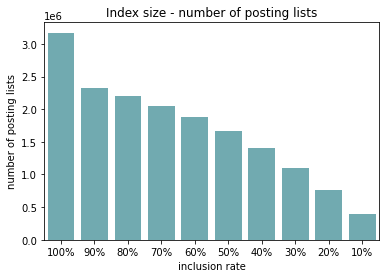

Summary_100%    3170464
Summary_90%     2329056
Summary_80%     2203697
Summary_70%     2054670
Summary_60%     1876862
Summary_50%     1662154
Summary_40%     1404645
Summary_30%     1101520
Summary_20%      758946
Summary_10%      389067
Name: Index size, dtype: object

In [8]:
# index size - number of posting lists
def compare_index_size(sizes, title):
    data = pd.to_numeric(sizes).to_list()
    plot_barchart(title, PLOT_X, data, 'inclusion rate', 'number of posting lists')

compare_index_size(summary.loc['Index size'], "Index size - number of posting lists")
summary.loc['Index size']

## Documnet list length comparison

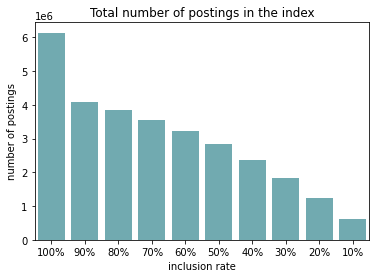

Total number of postings:


[6135480,
 4077222,
 3834630,
 3556792,
 3225673,
 2831084,
 2358297,
 1819907,
 1229502,
 612368]

In [9]:
freq_tables = results['termfreq']
posting_list_length_distribution = [table['posting_count'].value_counts().sort_index(inplace=False) for table in freq_tables]
total_posting_counts = [sum(table['posting_count']) for table in freq_tables]
plot_barchart('Total number of postings in the index', PLOT_X, total_posting_counts, 'inclusion rate', 'number of postings')
print('Total number of postings:')
total_posting_counts

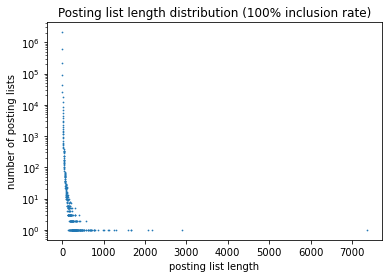

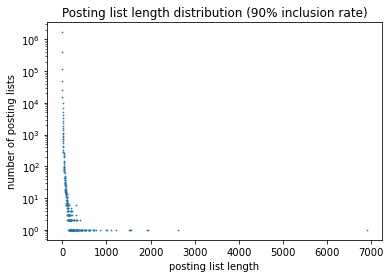

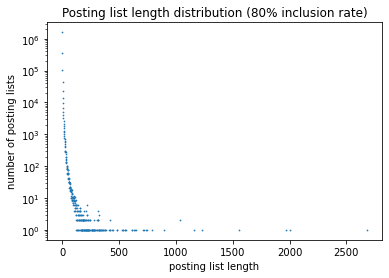

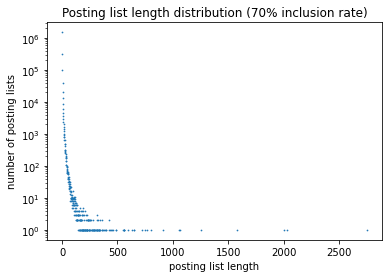

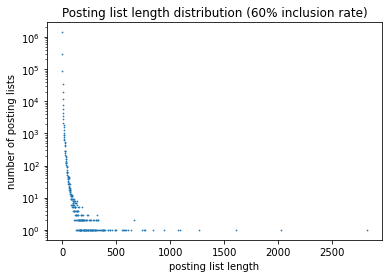

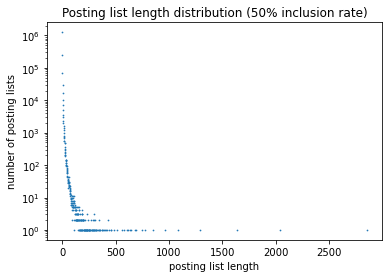

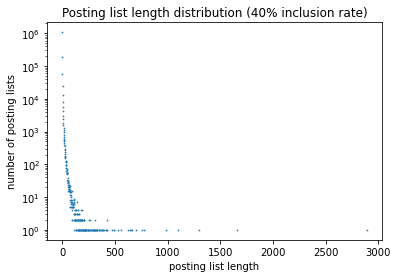

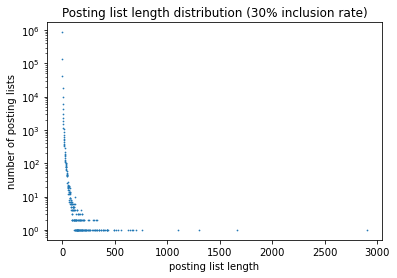

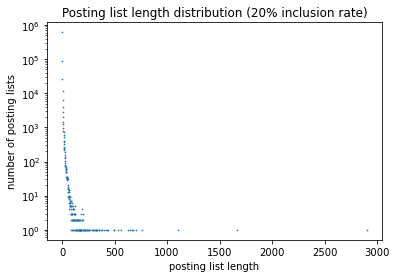

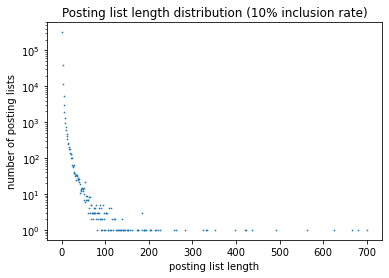

In [10]:
def compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution):
    for i in range(len(PLOT_X)):
        title = f'Posting list length distribution ({PLOT_X[i]} inclusion rate)'
        x = posting_list_length_distribution[i].index
        y = posting_list_length_distribution[i]
        plot_scatter(title, x, y, 'posting list length', 'number of posting lists', scale='log')   
compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution)

Average posting list length
[1.9351993903731441, 1.7505899385845596, 1.7400894950621615, 1.7310770099334687, 1.7186521971247752, 1.7032621526043916, 1.6789274158239271, 1.6521778996296028, 1.6200124910072653, 1.5739397070427459]


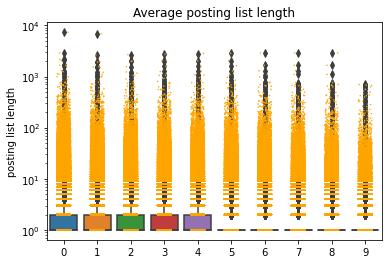

In [11]:
def compare_posting_list_len(PLOT_X, freq_tables):
    lengths = [table['posting_count'] for table in freq_tables]
    avgs = [sum(l)/len(l) for l in lengths]
    print("Average posting list length")
    print(avgs)
#     index15 = [int(round(len(l)*0.15,0)) for l in lengths]
#     index85 = [int(round(len(l)*0.85,0)) for l in lengths]
#     nooutlier_lengths = [ lengths[i][index15[i]:index85[i]] for i in range(len(lengths))]
    plot_boxplot(f'Average posting list length', lengths, 'posting list length', scale='log')
    
compare_posting_list_len(PLOT_X, freq_tables)

## Query Recall - compare to single term gamma=1 result

In [12]:
truth = pd.read_csv('./single_term_ground_truth.csv', header=None)

In [13]:
query_result_similarity_lookup = results['query_result_similarity_lookup']
query_result_similarity_lookup

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Result_40%,Result_30%,Result_20%,Result_10%,...,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%,Lookups_40%,Lookups_30%,Lookups_20%,Lookups_10%
0,26531,26531,-1,26531,26531,26531,189567,26531,189567,189567,...,22055,4480,-1,5096,3332,3024,144,767,24,9
1,2559,2559,2559,2559,2559,2559,2559,2559,2559,2559,...,112365,106260,3960,4092,243,208,182,182,125,1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21885,-1,-1,-1,-1,-1,-1,-1,-1,139648,139648,...,-1,-1,-1,-1,-1,-1,-1,-1,2,1
21886,-1,-1,-1,-1,-1,-1,-1,-1,-1,91619,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,2
21887,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21888,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [14]:
has_true_similar = truth[0] != -1
true_similar = truth[has_true_similar]
term_pair_results = query_result_similarity_lookup[has_true_similar]
num_true_similar = true_similar.shape[0]
has_true_similar
true_similar

,0
0,189567
1,146028
8,44802
12,170152
15,102434
...,...
21878,197554
21880,197554
21881,93654
21884,178680


In [15]:
num_correct_searches = []
correct_searches = []
for i in range(len(QUERY_RESULT_COL)):
    is_correct_search = true_similar[0] == term_pair_results[QUERY_RESULT_COL[i]]
    correct_search = term_pair_results[is_correct_search]
    correct_searches.append(correct_search)
    num_correct_searches.append(correct_search.shape[0])
print('Number of true similar tweets that we found: ')
num_correct_searches

Number of true similar tweets that we found: 


[2761, 2497, 2588, 2721, 2831, 2991, 3131, 3151, 3112, 2574]

Using 100% of terms, we can find 38.1% truly similar tweets
Using 90% of terms, we can find 34.46% truly similar tweets
Using 80% of terms, we can find 35.71% truly similar tweets
Using 70% of terms, we can find 37.55% truly similar tweets
Using 60% of terms, we can find 39.06% truly similar tweets
Using 50% of terms, we can find 41.27% truly similar tweets
Using 40% of terms, we can find 43.2% truly similar tweets
Using 30% of terms, we can find 43.48% truly similar tweets
Using 20% of terms, we can find 42.94% truly similar tweets
Using 10% of terms, we can find 35.52% truly similar tweets


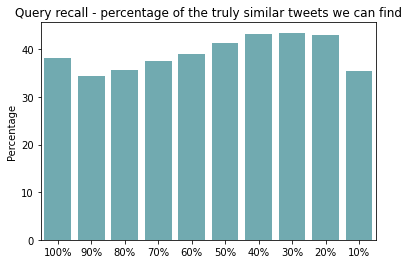

In [16]:
def compare_query_recall(recalls, title): 
    layer = sns.barplot(x=PLOT_X, y=recalls, color="#66B3BA")
    plt.title(title)
    layer.set(ylabel='Percentage')
    plt.show()

recalls = []
true_searches = []
for i in range(len(num_correct_searches)):
    true_searches.append(num_correct_searches[i])
    recall = round((num_correct_searches[i]/num_true_similar) * 100, 2)
    recalls.append(recall)
    chance = PLOT_X[i]
    print('Using {} of terms, we can find {}% truly similar tweets'.format(chance, recall))
    
compare_query_recall(recalls, 'Query recall - percentage of the truly similar tweets we can find')

## Query Recall - compare to term pair gamma=1 result

In [17]:
query_result_similarity_lookup = results['query_result_similarity_lookup']
query_result_similarity_lookup

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Result_40%,Result_30%,Result_20%,Result_10%,...,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%,Lookups_40%,Lookups_30%,Lookups_20%,Lookups_10%
0,26531,26531,-1,26531,26531,26531,189567,26531,189567,189567,...,22055,4480,-1,5096,3332,3024,144,767,24,9
1,2559,2559,2559,2559,2559,2559,2559,2559,2559,2559,...,112365,106260,3960,4092,243,208,182,182,125,1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21885,-1,-1,-1,-1,-1,-1,-1,-1,139648,139648,...,-1,-1,-1,-1,-1,-1,-1,-1,2,1
21886,-1,-1,-1,-1,-1,-1,-1,-1,-1,91619,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,2
21887,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21888,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [18]:
has_true_similar = query_result_similarity_lookup[QUERY_RESULT_COL[0]] != -1
true_similar = query_result_similarity_lookup[has_true_similar]
num_true_similar = true_similar.shape[0]
true_similar

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Result_40%,Result_30%,Result_20%,Result_10%,...,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%,Lookups_40%,Lookups_30%,Lookups_20%,Lookups_10%
0,26531,26531,-1,26531,26531,26531,189567,26531,189567,189567,...,22055,4480,-1,5096,3332,3024,144,767,24,9
1,2559,2559,2559,2559,2559,2559,2559,2559,2559,2559,...,112365,106260,3960,4092,243,208,182,182,125,1
18,196085,196085,196085,196085,196085,196085,196085,196085,196085,196085,...,30,24,24,6,6,4,3,3,3,2
26,73525,73525,73525,73525,-1,-1,-1,-1,-1,182442,...,930,336,304,344,-1,-1,-1,-1,-1,2
29,1582,1582,1582,1582,1582,1582,1582,1582,1582,-1,...,2247,1458,1168,840,540,280,36,3,2,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21874,197342,197342,197342,197342,197342,197342,197342,197342,197342,197342,...,10,10,10,8,5,5,3,2,2,1
21875,197554,197554,197554,197554,197554,197554,197554,197554,197554,197554,...,21,20,18,17,17,14,10,10,4,2
21878,197554,197554,197554,197554,197554,197554,197554,197554,197554,197554,...,21,20,18,17,17,14,10,10,4,2
21880,197554,197554,197554,197554,197554,197554,197554,197554,197554,197554,...,21,20,18,17,17,14,10,10,4,2


In [19]:
num_correct_searches = []
correct_searches = []
for i in range(len(QUERY_RESULT_COL)):
    is_correct_search = true_similar[QUERY_RESULT_COL[0]] == true_similar[QUERY_RESULT_COL[i]]
    correct_search = true_similar[is_correct_search]
    correct_searches.append(correct_search)
    num_correct_searches.append(correct_search.shape[0])
print('Number of true similar tweets that we found: ')
num_correct_searches

Number of true similar tweets that we found: 


[4226, 3668, 3671, 3737, 3773, 3685, 3640, 3373, 3093, 2480]

Using 100% of terms, we can find 100.0% truly similar tweets
Using 90% of terms, we can find 86.8% truly similar tweets
Using 80% of terms, we can find 86.87% truly similar tweets
Using 70% of terms, we can find 88.43% truly similar tweets
Using 60% of terms, we can find 89.28% truly similar tweets
Using 50% of terms, we can find 87.2% truly similar tweets
Using 40% of terms, we can find 86.13% truly similar tweets
Using 30% of terms, we can find 79.82% truly similar tweets
Using 20% of terms, we can find 73.19% truly similar tweets
Using 10% of terms, we can find 58.68% truly similar tweets


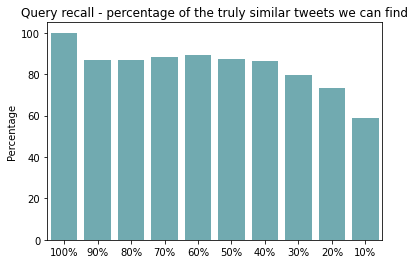

In [20]:
def compare_query_recall(recalls, title): 
    layer = sns.barplot(x=PLOT_X, y=recalls, color="#66B3BA")
    plt.title(title)
    layer.set(ylabel='Percentage')
    plt.show()

recalls = []
true_searches = []
for i in range(len(num_correct_searches)):
    true_searches.append(num_correct_searches[i])
    recall = round((num_correct_searches[i]/num_true_similar) * 100, 2)
    recalls.append(recall)
    chance = PLOT_X[i]
    print('Using {} of terms, we can find {}% truly similar tweets'.format(chance, recall))
    
compare_query_recall(recalls, 'Query recall - percentage of the truly similar tweets we can find')

## Query Precision

In [21]:
# is_predict_similar = query_result_similarity_lookup['Result_75%'] != -1
# predict_similar = query_result_similarity_lookup[is_predict_similar]
# num_predict_similar = predict_similar.shape[0]
# predict_similar
num_predict_similar_lst = []
predict_similar_lst = []
for i in range(len(QUERY_RESULT_COL)):
    is_predict_similar = query_result_similarity_lookup[QUERY_RESULT_COL[i]] != -1
    predict_similar = query_result_similarity_lookup[is_predict_similar]
    predict_similar_lst.append(predict_similar)
    num_predict_similar_lst.append(predict_similar.shape[0])
print("The number of tweets that we think are similar: ")
num_predict_similar_lst

The number of tweets that we think are similar: 


[4226, 3995, 4103, 4241, 4399, 4622, 4969, 5522, 6332, 7058]

Using 100% of terms, 100.0% tweets that we found similar are truly similar tweets
Using 90% of terms, 91.81% tweets that we found similar are truly similar tweets
Using 80% of terms, 89.47% tweets that we found similar are truly similar tweets
Using 70% of terms, 88.12% tweets that we found similar are truly similar tweets
Using 60% of terms, 85.77% tweets that we found similar are truly similar tweets
Using 50% of terms, 79.73% tweets that we found similar are truly similar tweets
Using 40% of terms, 73.25% tweets that we found similar are truly similar tweets
Using 30% of terms, 61.08% tweets that we found similar are truly similar tweets
Using 20% of terms, 48.85% tweets that we found similar are truly similar tweets
Using 10% of terms, 35.14% tweets that we found similar are truly similar tweets


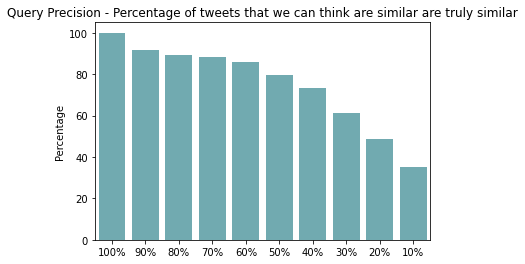

In [22]:
def compare_query_precision(precisions, title): 
    layer = sns.barplot(x=PLOT_X, y=precisions, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

precisions = []
for i in range(len(num_predict_similar_lst)):
    precision = round((num_correct_searches[i]/num_predict_similar_lst[i]) * 100, 2)
    precisions.append(precision)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% tweets that we found similar are truly similar tweets'.format(chance, precision))
    
compare_query_precision(precisions, 'Query Precision - Percentage of tweets that we can think are similar are truly similar')

## Number of searches that need fewer lookups

In [23]:
correct_search

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Result_40%,Result_30%,Result_20%,Result_10%,...,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%,Lookups_40%,Lookups_30%,Lookups_20%,Lookups_10%
1,2559,2559,2559,2559,2559,2559,2559,2559,2559,2559,...,112365,106260,3960,4092,243,208,182,182,125,1
18,196085,196085,196085,196085,196085,196085,196085,196085,196085,196085,...,30,24,24,6,6,4,3,3,3,2
30,2559,2559,2559,2559,2559,2559,2559,2559,2559,2559,...,112365,106260,3960,4092,243,208,182,182,125,1
40,708,708,708,708,708,708,708,708,708,708,...,330,225,195,165,150,98,15,15,6,1
55,196844,-1,-1,-1,-1,-1,196844,196844,196844,196844,...,819,-1,-1,-1,-1,-1,196,175,72,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21874,197342,197342,197342,197342,197342,197342,197342,197342,197342,197342,...,10,10,10,8,5,5,3,2,2,1
21875,197554,197554,197554,197554,197554,197554,197554,197554,197554,197554,...,21,20,18,17,17,14,10,10,4,2
21878,197554,197554,197554,197554,197554,197554,197554,197554,197554,197554,...,21,20,18,17,17,14,10,10,4,2
21880,197554,197554,197554,197554,197554,197554,197554,197554,197554,197554,...,21,20,18,17,17,14,10,10,4,2


In [24]:
query_of_less_lookups = []
less_search_lst = []
for i in range(len(QUERY_LOOKUPS_COL)):
    if i != 0:
        is_less_search = correct_searches[i][QUERY_LOOKUPS_COL[0]] > correct_searches[i][QUERY_LOOKUPS_COL[i]]
        less_search = correct_searches[i][is_less_search]
        less_search_lst.append(less_search)
        query_of_less_lookups.append(less_search.shape[0])
    else:
        less_search_lst.append(None)
        query_of_less_lookups.append(0)
print("The number of tweets that need less lookups before correctly finding the true similar tweets: ")
query_of_less_lookups

The number of tweets that need less lookups before correctly finding the true similar tweets: 


[0, 3542, 3653, 3732, 3772, 3684, 3640, 3373, 3093, 2480]

Using 100% of terms, 0.0% queries need less lookups before correctly finding the true similar tweets
Using 90% of terms, 96.56% queries need less lookups before correctly finding the true similar tweets
Using 80% of terms, 99.51% queries need less lookups before correctly finding the true similar tweets
Using 70% of terms, 99.87% queries need less lookups before correctly finding the true similar tweets
Using 60% of terms, 99.97% queries need less lookups before correctly finding the true similar tweets
Using 50% of terms, 99.97% queries need less lookups before correctly finding the true similar tweets
Using 40% of terms, 100.0% queries need less lookups before correctly finding the true similar tweets
Using 30% of terms, 100.0% queries need less lookups before correctly finding the true similar tweets
Using 20% of terms, 100.0% queries need less lookups before correctly finding the true similar tweets
Using 10% of terms, 100.0% queries need less lookups before correctly finding the t

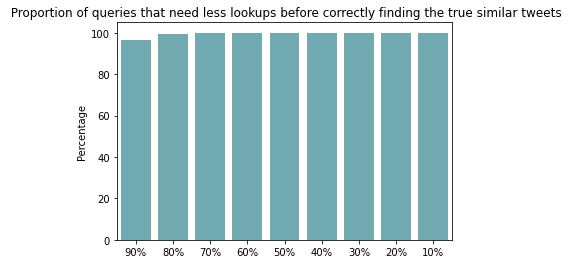

In [25]:
def compare_number_of_tweets_need_less_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X[1:], y=reduces, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

proportions = []
for i in range(len(query_of_less_lookups)):
    proportion = round((query_of_less_lookups[i] / num_correct_searches[i]) * 100, 2)
    proportions.append(proportion)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% queries need less lookups before correctly finding the true similar tweets'.format(chance, proportion))
    
compare_number_of_tweets_need_less_lookups(proportions[1:], ' Proportion of queries that need less lookups before correctly finding the true similar tweets')

## Number of average lookups

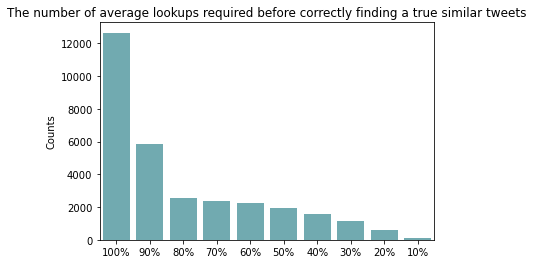

In [26]:
def compare_number_of_avg_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X, y=reduces, color="#66B3BA")
    layer.set(ylabel='Counts')
    plt.title(title)
    plt.show()

avg_lookups = []
for i in range(len(QUERY_LOOKUPS_COL)):
    avg_lookup = np.average(np.array(correct_searches[i][QUERY_LOOKUPS_COL[i]]))
    avg_lookups.append(avg_lookup)

compare_number_of_avg_lookups(avg_lookups, 'The number of average lookups required before correctly finding a true similar tweets')

In [27]:
reduces = []
print('Comparing to using all the terms:')
for i in range(len(avg_lookups)):
    if i != 0:
        reduce = round(((avg_lookups[0] - avg_lookups[i]) / avg_lookups[0]) * 100, 2)
        reduces.append(reduce)
        chance = PLOT_X[i]
        print('By using {} of terms, {}% less lookups are needed for correctly finding a true similar tweets'.format(chance, reduce))

Comparing to using all the terms:
By using 90% of terms, 53.89% less lookups are needed for correctly finding a true similar tweets
By using 80% of terms, 79.81% less lookups are needed for correctly finding a true similar tweets
By using 70% of terms, 81.06% less lookups are needed for correctly finding a true similar tweets
By using 60% of terms, 82.21% less lookups are needed for correctly finding a true similar tweets
By using 50% of terms, 84.56% less lookups are needed for correctly finding a true similar tweets
By using 40% of terms, 87.76% less lookups are needed for correctly finding a true similar tweets
By using 30% of terms, 91.11% less lookups are needed for correctly finding a true similar tweets
By using 20% of terms, 95.39% less lookups are needed for correctly finding a true similar tweets
By using 10% of terms, 99.24% less lookups are needed for correctly finding a true similar tweets


## Index time comparison

In [28]:
index_time = results['index_time']
index_time

,Index_time_run1_100%,Index_time_run2_100%,Index_time_run3_100%,Index_time_run1_90%,Index_time_run2_90%,Index_time_run3_90%,Index_time_run1_80%,Index_time_run2_80%,Index_time_run3_80%,Index_time_run1_70%,...,Index_time_run3_40%,Index_time_run1_30%,Index_time_run2_30%,Index_time_run3_30%,Index_time_run1_20%,Index_time_run2_20%,Index_time_run3_20%,Index_time_run1_10%,Index_time_run2_10%,Index_time_run3_10%
0,38.1025,37.6117,42.7525,69.6506,57.1030,70.4576,63.6683,76.8271,92.2233,84.2118,...,95.6374,87.3555,83.7089,91.4511,89.0816,88.8722,98.2122,88.9201,94.7087,91.0947
1,29.4854,30.7848,38.2575,38.7646,38.2742,33.1541,34.6232,35.2364,32.3712,42.2761,...,42.0209,49.4385,39.2924,45.4968,42.8530,41.5674,46.0619,46.1709,47.7637,46.3901
2,22.8982,23.6489,28.3426,27.1549,35.0395,22.7278,25.0339,30.3159,24.9694,31.8369,...,42.6725,47.0045,41.4335,46.3812,43.5297,49.5595,45.0938,48.3845,41.0232,42.6995
3,21.8765,22.0616,21.4749,23.1595,32.7185,21.5951,22.3207,27.7392,24.5520,41.8465,...,31.0042,36.1746,32.2494,31.8015,31.6446,36.7867,34.7665,35.8703,32.6636,30.5181
4,21.4558,21.3702,21.0218,40.5941,36.6804,45.3759,24.9711,25.0966,24.5957,33.2278,...,29.4539,33.6277,30.8369,31.3546,31.0911,32.6518,33.3727,34.2690,33.5700,31.4923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,13.5678,11.4888,10.9730,14.7963,14.9323,19.8683,15.8188,17.5058,16.8955,18.9863,...,29.1082,29.0873,25.9554,24.7817,25.1881,24.7024,25.9680,23.3862,26.1472,42.5383
193,13.1624,12.0853,12.1960,15.3246,14.7620,14.2120,15.4923,17.1283,16.5502,17.9580,...,24.6586,26.5725,25.4713,23.9623,24.8227,24.6370,23.5828,23.5705,25.5965,24.9153
194,80.7046,12.3192,11.4016,14.5918,14.5950,14.4351,15.5742,17.2585,22.9008,20.0893,...,23.7582,29.3567,26.2957,25.3127,25.9860,32.5610,25.9083,24.7267,26.7664,25.7222
195,13.8387,14.0482,11.1292,13.7865,14.3541,13.7965,15.2550,21.5404,17.9707,17.1152,...,21.9282,25.6498,23.6110,22.7185,23.9163,33.3673,23.0438,22.7057,23.8548,23.7211


By using 100% of terms, the average time for indexing 1000 tweets is 14.3495 milliseconds
By using 90% of terms, the average time for indexing 1000 tweets is 18.5978 milliseconds
By using 80% of terms, the average time for indexing 1000 tweets is 20.3477 milliseconds
By using 70% of terms, the average time for indexing 1000 tweets is 22.267 milliseconds
By using 60% of terms, the average time for indexing 1000 tweets is 24.3858 milliseconds
By using 50% of terms, the average time for indexing 1000 tweets is 25.3491 milliseconds
By using 40% of terms, the average time for indexing 1000 tweets is 26.607 milliseconds
By using 30% of terms, the average time for indexing 1000 tweets is 29.1171 milliseconds
By using 20% of terms, the average time for indexing 1000 tweets is 27.9036 milliseconds
By using 10% of terms, the average time for indexing 1000 tweets is 26.7595 milliseconds


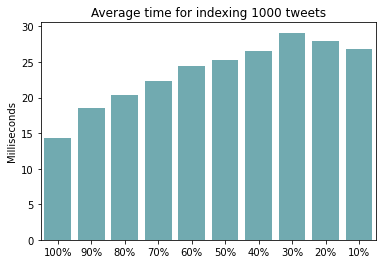

In [29]:
def compare_time(avg_time, title): 
    layer = sns.barplot(x=PLOT_X, y=avg_time, color="#66B3BA")
    layer.set(ylabel='Milliseconds')
    plt.title(title)
    plt.show()

index_time_avgs = []
for col in index_time.columns:
    index_time_avgs.append(np.average(np.array(index_time[col])))

index_time_avgs2 = []
c = 0
acc = 0
for avg in index_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        index_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(index_time_avgs2)):
    print('By using {} of terms, the average time for indexing {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, index_time_avgs2[i]))
compare_time(index_time_avgs2, 'Average time for indexing {} tweets'.format(INDEX_TIME_UNIT))

## Query time comparison

In [30]:
query_time = results['query_time']
query_time

,Query_time_run1_100%,Query_time_run2_100%,Query_time_run3_100%,Query_time_run1_90%,Query_time_run2_90%,Query_time_run3_90%,Query_time_run1_80%,Query_time_run2_80%,Query_time_run3_80%,Query_time_run1_70%,...,Query_time_run3_40%,Query_time_run1_30%,Query_time_run2_30%,Query_time_run3_30%,Query_time_run1_20%,Query_time_run2_20%,Query_time_run3_20%,Query_time_run1_10%,Query_time_run2_10%,Query_time_run3_10%
0,6.0003,4.3601,6.3974,2.0875,0.9283,0.9190,1.1961,2.0573,1.4712,2.0649,...,1.3901,2.3137,1.7640,1.5241,1.4002,1.4012,1.3450,2.2024,1.6856,1.3413
1,136.0755,142.4306,133.9374,111.7264,116.8756,118.1740,92.3872,92.2918,225.9143,201.5292,...,71.5290,66.4995,63.3462,64.0360,53.5951,51.9207,48.3385,37.2085,38.3905,38.3050
2,61.2796,60.9556,69.4231,36.7146,38.0579,39.6881,42.5336,45.8669,58.4357,45.2538,...,54.5479,58.2948,59.6762,57.4541,47.0771,47.7529,45.1827,33.9777,34.6097,33.3600
3,57.9262,59.5272,63.2470,35.3068,36.0032,37.3577,30.5812,33.0155,31.6815,34.0247,...,33.6214,36.7969,34.1703,33.1300,39.6007,40.4741,40.3161,30.1017,33.8798,31.5533
4,63.4056,64.7091,74.0273,36.0396,38.5451,39.2976,31.3543,33.4836,32.1524,33.3951,...,32.7933,34.8301,34.0900,31.6799,42.4184,37.7065,36.6350,28.4591,31.5546,29.5893
5,184.6447,65.1952,76.6225,39.1133,41.4723,41.6975,31.8631,33.7826,32.8898,33.0136,...,31.6687,33.4315,33.2210,29.9932,34.1427,28.3402,28.4514,25.4579,29.2621,25.2891
6,89.5507,94.4664,251.4905,51.4905,50.3648,52.8900,37.4234,40.2166,36.0356,38.7763,...,34.3425,36.5503,33.9094,33.2659,28.5363,29.8753,30.6845,26.9570,31.6224,27.6233
7,112.8848,117.7875,134.5303,67.2468,70.3477,72.1176,40.4180,41.7937,39.3120,42.1408,...,38.3861,38.0323,35.9399,35.0246,29.1454,30.0011,29.6993,25.8254,33.3310,25.6389
8,96.0726,108.1065,113.7957,58.7500,61.3429,61.0079,39.1526,41.1574,38.5953,41.2094,...,34.6362,35.4487,33.0661,32.3687,28.9950,28.5584,29.7506,24.3543,30.5237,24.3467
9,89.1728,105.3048,113.1705,52.7606,54.5392,57.3456,39.2217,41.5559,37.9741,39.6712,...,34.4271,36.8133,31.6923,89.9192,28.1701,28.0372,28.9311,24.4326,30.9375,24.8019


By using 100% of terms, the average time for querying 1000 tweets is 70.8758 milliseconds
By using 90% of terms, the average time for querying 1000 tweets is 45.1234 milliseconds
By using 80% of terms, the average time for querying 1000 tweets is 38.0577 milliseconds
By using 70% of terms, the average time for querying 1000 tweets is 37.7104 milliseconds
By using 60% of terms, the average time for querying 1000 tweets is 38.1275 milliseconds
By using 50% of terms, the average time for querying 1000 tweets is 37.624 milliseconds
By using 40% of terms, the average time for querying 1000 tweets is 33.0742 milliseconds
By using 30% of terms, the average time for querying 1000 tweets is 35.6913 milliseconds
By using 20% of terms, the average time for querying 1000 tweets is 31.8559 milliseconds
By using 10% of terms, the average time for querying 1000 tweets is 27.5981 milliseconds


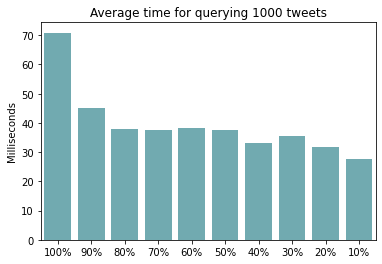

In [31]:
query_time_avgs = []
for col in query_time.columns:
    query_time_avgs.append(np.average(np.array(query_time[col])))

query_time_avgs2 = []
c = 0
acc = 0
for avg in query_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        query_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(query_time_avgs2)):
    print('By using {} of terms, the average time for querying {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, query_time_avgs2[i]))
compare_time(query_time_avgs2, 'Average time for querying {} tweets'.format(INDEX_TIME_UNIT))